In [2]:
%load_ext autoreload
%autoreload 2
import dotenv
dotenv.load_dotenv()
from mlworkflow import PickledDataset, TransformedDataset, FilteredDataset, CachedDataset
from experimentator import find
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

# Ballistic trajectories annotation

In [ ]:
import matplotlib as mpl
mpl.use('PDF')

import pickle
from experimentator import find, build_experiment
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import os
import datetime
import itertools
from types import SimpleNamespace
import glob
import cv2
from collections import defaultdict
from pprint import pprint
#from deepsport_utilities.ds.instants_dataset import *
from deepsport_utilities import import_dataset
from deepsport_utilities.utils import VideoMaker, colorify_heatmap

from dataset_utilities.ds.raw_sequences_dataset.ballistic_trajectories import *
try:
    ds = PickledDataset(find("ballistic_annotation_dataset.pickle"))
except FileNotFoundError:
    from dataset_utilities.ds.instants_dataset import InstantsDataset
    from dataset_utilities.providers import AWSSession
    ids = InstantsDataset(sport="basketball", session=AWSSession('984684664984_KmDeepLearningAdmins'), progress_wrapper=tqdm)
    ds = PickledDataset(find("instants_ballistic_trajectories_600ms.pickle")) # _filtered_corrected
    ds = TransformedDataset(ds, [InterpolateBallAnnotationsTransform(ids)])
    ds = FilteredDataset(ds, lambda k: k.arena_label == 'KS-FR-BOURGEB')
    
def measure_quality(calib, true, pred):
    error3D = np.linalg.norm(true-pred, axis=0)
    error2D = np.linalg.norm(calib.project_3D_to_2D(true)-calib.project_3D_to_2D(pred), axis=0)
    return np.mean(error3D), np.mean(error2D), np.max(error3D), np.max(error2D)

from dataset_utilities.ds.raw_sequences_dataset.ballistic_trajectories import *
from collections import defaultdict
plt.rcParams['text.usetex'] = True


data = defaultdict(lambda: defaultdict(list))
for tidx, k in tqdm(enumerate(ds.keys)):
    if k.timestamp not in [1600275804470, 1600276045576]: # selected for illustration in thesis
        continue
        
    #if k.timestamp not in [1600275975604, 1600275850078]:
    #    pass#continue

    instants = Trajectory(ds.query_item(k))
    balls = [i.ball for i in instants if i.ball is not None and i.ball.origin == 'annotation']
    if len(balls) == len(instants) or len(balls) == 2:
        pass#continue
    
    # ignore ballistic trajectories not fully annotated
    if len(balls) != len(instants):
        continue

    print(f"timestamp >= {instants[0].key.timestamp} && timestamp <= {instants[-1].key.timestamp}")
    print("time in the full video: ", datetime.timedelta(seconds=instants[0].frame_indices[0]/(fps:=15)))

    ax = plt.figure(figsize=(20,20)).gca()
    instants.illustsrate(ax, grayscale=True)
    #ax.set_title(f"{instants[0].key.timestamp} -- {instants[-1].key.timestamp}")
    method = None#'Nelder-Mead'
    # FAIL: 'trust-constr', 'BFGS'
    # 'SLSQP'        errors init2D: 0.46, 2.36    init3D: .46, 3.8
    # 'L-BFGS-B'     errors init2D: 0.48, 0.11    init3D: 1.3, 3.6
    # 'TNC'          errors init2D: 0.9, ---      init3D: 1.6, ---     (max it reached)
    # 'Nelder-Mead'  errors init2D: 0.52, 1.37    init3D: 0.57, 1.43   (max it reached)
    options = None#{'iprint':20}
    for N in tqdm([2, 3, 4, 'all'], leave=False):
        for fitter, color, N, name in tqdm([
            #(ParabolaFitter(Fit2Dmean, Parabola2DLinearFitter()), "red", N, "2DParabola"),
            #(BallisticFitter(Fit2Dmean, Parabola2DLinearFitter(), with_lift=False), "yellow", N, "2DBallistic (no lift)"),
            #(BallisticFitter(Fit2Dmean, Parabola2DLinearFitter(), with_lift=True), "blue", N, "2DBallistic (with lift)"),
            (Parabola3DLinearFitter(), 'orange', N, "3DParabola"),
            (BallisticFitter(Fit3Dmean, Parabola3DLinearFitter(), with_lift=False), "cyan", N, "3DBallistic (no lift)"),
            (BallisticFitter(Fit3Dmean, Parabola3DLinearFitter(), with_lift=True), "purple", N, "3DBallistic (with lift)"),
        ], leave=False):
    #for fitter, color, N, name in tqdm([
    #    (BallisticFitter(Fit2Dmean, Parabola2DLinearFitter(), with_lift=True), "blue", 'all', r"\textbf{Parabola} from all points (fit in 2D)"),
    #    (Parabola3DLinearFitter(), 'orange', 2, r"\textbf{Parabola} from 2 points (fit in 3D)"),
    #    (Parabola3DLinearFitter(), 'magenta', 'all', r"\textbf{Parabola} from all points (fit in 3D)"),
    #    (BallisticFitter(Fit3Dmean, Parabola3DLinearFitter(), with_lift=True), "cyan", 3, r"\textbf{Ballistic (with lift)} from 3 points (fit in 3D)"),
    #], leave=False):
            # use N instants for fitting model (or all if N is none)
            if N is not None:
                indices = np.linspace(0, len(instants)-1, N if isinstance(N, int) else len(instants)).astype(np.int)
            else:
                indices = np.array([i for i, instant in enumerate(instants) if instant.ball and instant.ball.origin == 'annotation'])
            timestamps = np.array([i.timestamps[i.ball.camera] for i in instants])[indices]
            points3D = Point3D([i.ball.center for i in instants])[:,indices]
            calibs = [instant.calibs[instant.ball.camera] for index, instant in enumerate(instants) if index in indices]

            model = fitter(calibs, points3D, timestamps)
            if model is None:
                continue

            timestamps = np.array([i.timestamps[i.ball.camera] for i in instants])
            points3D = Point3D([i.ball.center for i in instants])
            preds3D = model(timestamps)
            errors = measure_quality(instants.calib, points3D, preds3D)
            label = name or fitter.label
            data[label][N].append(errors)
            points3D = preds3D
            calib = instants.calib
            points2D = calib.project_3D_to_2D(points3D)
            points3D.z = 0
            pi = points2D
            pg = calib.project_3D_to_2D(points3D)
            ax.plot(pi.x, pi.y, ".-", color=color, zorder=300, linewidth=1, markersize=10, label=name or fitter.label)
            ax.plot(pg.x, pg.y, ".-", color=color, zorder=500, linewidth=1)
            ax.legend(loc="lower right", fontsize=20)#, zorder=200)

    #plt.savefig(f'{k.timestamp}.pdf', bbox_inches='tight')
    #plt.show()
    plt.close()
    
for metric, f in [
    ("mean3D", lambda x: x/100),
    ("mean2D", lambda x: x)
]:
    lines = []
    print(metric)
    for modelname in data.keys():
        line = []
        for N in [2, 3, 4, 'all']:
            if N not in data[modelname]:
                line.append(" - ")
            else:
                vv = list(zip(*data[modelname][N]))
                metricidx = ["mean3D", "mean2D", "max3D", "max2D"].index(metric)
                line.append(f"${f(np.mean(vv[metricidx])):.02f}\\pm {f(np.std(vv[metricidx])):.02f}$".replace("0.", "."))
        lines.append(f"& \\textbf{{{modelname}}} &" + " & ".join(line) + "\\\\")
    print("\n".join(sorted(lines)))

# Sequences dataset description

In [ ]:
from pprint import pprint
ds = PickledDataset(find("raw_sequences_dataset.pickle"))
for k in ds.keys:
    item = ds.query_item(k)
    frame = next(iter(item.yield_frames()))[0]
    try:
        fps = int(item.game_info['stream_configurations'][0]['fps'])
    except:
        fps = 0
        continue
    print("\t&\t".join([
        f"\\textsc{{{k.arena_label.lower()}}}",
        str(item.metadata['num_cameras']),
        f"${frame.width} \\times {frame.height}$",
        str(item.metadata['num_files']),
        str(fps)
    ]), "\\\\")

# Ball height distribution

In [ ]:
from collections import defaultdict
from mlworkflow import PickledDataset
from experimentator import find
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from calib3d import Point3D
import numpy as np

ground = lambda p: Point3D(p.x, p.y, 0)

ds = PickledDataset(find("ballsize_dataset_256_with_detections_from_model_trained_on_full_dataset_new.pickle"))
h = defaultdict(list)
d = defaultdict(list)
for k in tqdm(ds.keys):
    name = type(k[0]).__name__
    item = ds.query_item(k)
    calib = item.calib
    ball = item.ball
    if ball.origin not in ['annotation', 'interpolation']:
        continue
    h[name].append(np.linalg.norm(calib.project_3D_to_2D(ball.center) - calib.project_3D_to_2D(ground(ball.center))))
    d[name].append(calib.compute_length2D(ball.center, 23)[0])

ds = PickledDataset(find("ballistic_ball_views.pickle"))
for k in tqdm(ds.keys):
    name = "ballistic"
    item = ds.query_item(k)
    calib = item.calib
    ball = item.ball
    if ball.origin not in ['annotation', 'interpolation']:
        continue
    h[name].append(np.linalg.norm(calib.project_3D_to_2D(ball.center) - calib.project_3D_to_2D(ground(ball.center))))
    d[name].append(calib.compute_length2D(ball.center, 23)[0])

In [ ]:
fig, axes = plt.subplots(1,2)
for k in h:
    label = {
        'InstantKey': 'DeepSport dataset',
        'SequenceInstantKey': 'Raw Sequences dataset (ballistics trajectories only)',
        'ballistic': 'Ballistic dataset'
    }[k]
    axes[0].hist(h[k], label=label, alpha=.5)
    axes[1].hist(d[k], label=label, alpha=.5)
axes[0].set_xlabel('ball height [px]')
axes[1].set_xlabel('ball diameter [px]')
axes[1].legend()

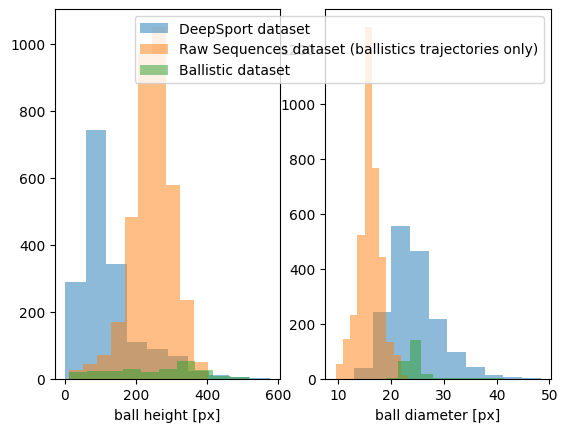

In [42]:
import os
from matplotlib import pyplot as plt
from experimentator import DataCollector
import numpy as np
from pyconfyg import Confyg

In [46]:
from mlworkflow import PickledDataset
from experimentator import find
from tqdm.auto import tqdm
from calib3d import Point2D
from deepsport_utilities.court import BALL_DIAMETER
ds = PickledDataset(find("camera_with_ball_visible_views.pickle"))
data = []
for k in tqdm(ds.keys):
    view = ds.query_item(k)
    calib=view.calib
    x = np.linalg.norm(Point2D(view.calib.width/2, view.calib.height/2) - view.calib.project_3D_to_2D(view.ball.center))
    x = x*(calib.K[0,0])/(view.calib.K[0,0]) # project to reference camera
    y = view.calib.compute_length2D(view.ball.center, BALL_DIAMETER)[0]
    data.append((x, y))

camera_with_ball_visible_views.pickle found in /globalscratch/users/g/v/gvanzand/camera_with_ball_visible_views.pickle


  0%|          | 0/1681 [00:00<?, ?it/s]

In [48]:
data2 = []
refcalib = Calib.load("calib_1936x1458.pickle")
ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))
for k in tqdm(ds.keys):
    for instant in ds.query_item(k):
        ball = instant.ball
        calib = instant.calibs[ball.camera]
        x = np.linalg.norm(Point2D(calib.width/2, calib.height/2) - calib.project_3D_to_2D(ball.center))
        x = x*(refcalib.K[0,0])/(calib.K[0,0]) # project to reference camera
        y = calib.compute_length2D(ball.center, BALL_DIAMETER)[0]
        data2.append((x, y))


instants_ballistic_trajectories_600ms_filtered.pickle found in /globalscratch/users/g/v/gvanzand/instants_ballistic_trajectories_600ms_filtered.pickle


OSError: Corrupted file

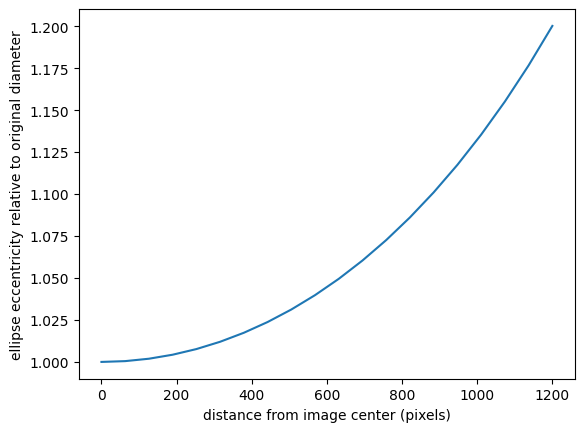

ValueError: not enough values to unpack (expected 2, got 0)

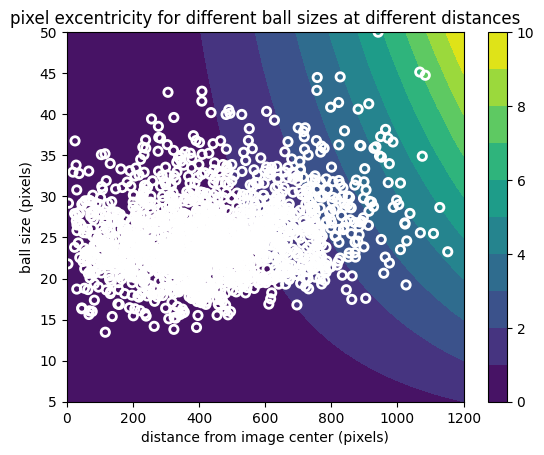

In [49]:
from calib3d import Calib
import matplotlib as mpl

refcalib = Calib.load("calib_1936x1458.pickle")
dist_max = 1200
fovx = np.arctan(dist_max/refcalib.K[0,0])
alpha = np.linspace(0, fovx, 20)
factor = 1/np.cos(alpha)
distance = alpha/fovx*dist_max
plt.plot(distance, factor)
plt.xlabel("distance from image center (pixels)")
plt.ylabel("ellipse eccentricity relative to original diameter")
plt.show()

sizes = np.arange(5, 51)
X, Y = np.meshgrid(distance, sizes)
Z = 1/np.cos(X*fovx/dist_max)*Y-Y
plt.contourf(X, Y, Z, levels=np.arange(11))
plt.colorbar()
plt.ylabel("ball size (pixels)")
plt.xlabel("distance from image center (pixels)")
plt.title("pixel excentricity for different ball sizes at different distances")
xs, ys = zip(*data)
plt.scatter(xs, ys, marker="o", facecolors='none', linewidths=2, edgecolor='white')
xs, ys = zip(*data2)
plt.scatter(xs, ys, marker="o", facecolors='none', linewidths=2, edgecolor='orange')
plt.show()

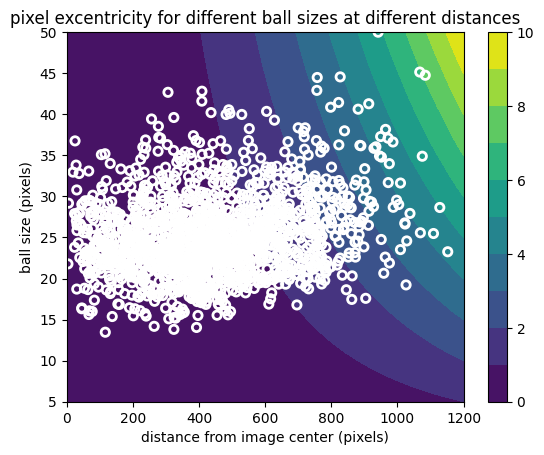

camera_with_ball_visible_views.pickle found in /globalscratch/users/g/v/gvanzand/camera_with_ball_visible_views.pickle


  0%|          | 0/1681 [00:00<?, ?it/s]

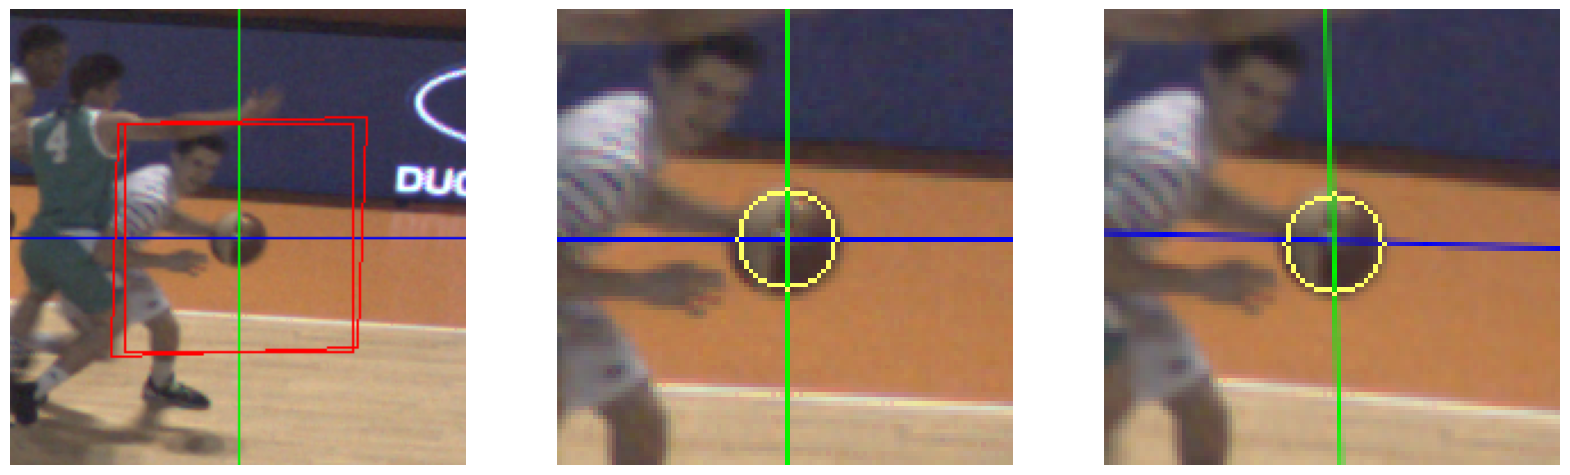

In [84]:
from deepsport_utilities.ds.instants_dataset.views_transforms import BallViewRandomCropperTransform
from deepsport_utilities.ds.instants_dataset import InstantKey
from tasks.ballistic import InstantRenderer
from calib3d import ProjectiveDrawer, compute_shear_rectification_matrix, Point2D
import numpy as np
import cv2

ir = InstantRenderer(None)

ds = PickledDataset(find("camera_with_ball_visible_views.pickle"))

for k in tqdm(ds.keys):
    view = ds.query_item(k)
    dist = np.linalg.norm(view.calib.project_3D_to_2D(view.ball.center) - Point2D(view.calib.K[0:2,2]))
    if dist < 1000:
        continue
    
    center = view.calib.project_3D_to_2D(view.ball.center)
    view.image[int(center.y), :] = (0, 0, 244)
    view.image[:, int(center.x)] = (0, 244, 0)

    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    
    for rectify, ax in zip([False, True], [axes[1], axes[2]]):
        t = BallViewRandomCropperTransform(scale_max=1, scale_min=1, margin=50, output_shape=(100,100), regenerate=True, rectify=rectify)
        v = t(k, view)
        ir.draw_ball(ProjectiveDrawer(v.calib, color=(244,20,200)), v.image, v.ball.center, color=(255, 255, 100), cross=False, projection=False)
        ax.imshow(v.image)
        ax.axis(False)
    
    v = view
    for rectify, margin, debug in zip([True, False, False], [50, 50, 100], [True, True, False]):
        t = BallViewRandomCropperTransform(scale_max=1, scale_min=1, margin=margin, output_shape=(2*margin,2*margin), debug=debug, regenerate=True, rectify=rectify)
        t.linewidth = 1
        v = t(k, v)
    axes[0].imshow(v.image)
    axes[0].axis(False)
    plt.show()
    break

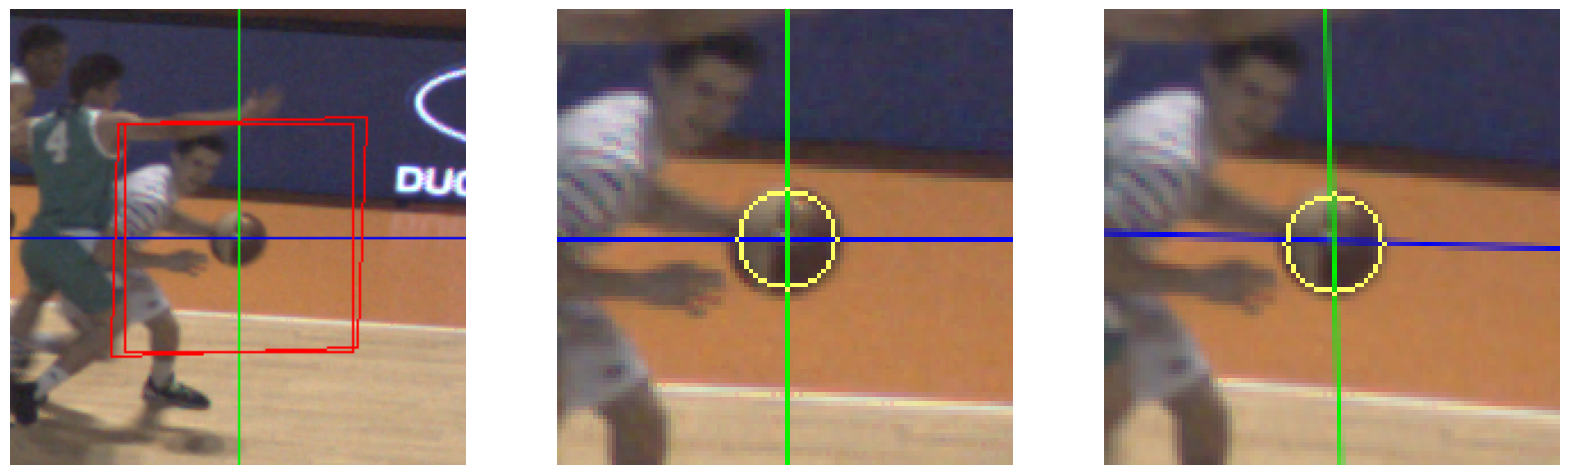

In [ ]:
fig = plt.figure()
ax = plt.gca()

detections = [1, 0, 1, 1, -1, 1, 1, 0, -1, 1, 0, 1, 1, 0, 1, 1, 0, 1]
ax.invert_yaxis()
models = [
    (0, 4.5, []),
    (2, 4.5, []),
    (3, 4.5, [3, 5, 6]),
    (3, 5, [3, 5, 6, 8]),
    (3, 6, [3, 5, 6, 8, 9]),
    (3, 7, [3, 5, 6, 8, 9]),
    (3, 8, [3, 5, 6, 8, 9, 11]),
    (3, 9, [3, 5, 6, 8, 9, 11]),
    (3, 10, [3, 5, 6, 8, 9, 11]),
    (3, 11, [3, 5, 6, 8, 9, 11]),
    (3, 12, [6, 8, 11, 12, 14]),
    (11, 4.5, []),
    (12, 4.5, []),
]
ax.fill_between([2.5, 11.5], -.5, len(models)-.5, zorder=.001, alpha=0.5, color=(.4, .7, .9), label="ballistic trajectory")

for f, d in enumerate(detections):
    if d:
        label = 'ball detections'#{1: 'TP', 0: 'FN', -1: 'FP'}[d]
        alpha = {1: 0, -1: 1}[d]
        xs = [f]*len(models)
        ys = range(len(models))
        ax.plot(xs, ys, marker="o", linestyle="", alpha=1, markersize=3, color='darkgray', zorder=1, label=label)

for j, (s, w, inliers) in enumerate(models):
    if l := len(inliers):
        lprev = len(models[j-1][2])
        if lprev == 0:
            color = (.8, .2, .2)
            label = 'valid model'
        elif lprev > l:
            color = (.6, .15, .15)
            label = 'invalid model'
        else:
            color = (.8, .2, .2)
            label = 'valid model'
    else:
        color = (1, .5, .5)
        label = 'no model'
    ax.plot([s, s+w], [j, j], linewidth=2, zorder=.1, color=color, solid_capstyle='round', label=label)
    for i in inliers:
        ax.plot(i, j, marker=".", linestyle="", markersize=13, zorder=.2, color=color, label="model inliers")
            

def legend_without_duplicate_labels(ax):
    from collections import OrderedDict
    handles, labels = ax.get_legend_handles_labels()
    legend = OrderedDict(zip(labels, handles))
    legend.move_to_end('model inliers')
    ax.legend(legend.values(), legend.keys(), framealpha=1)

legend_without_duplicate_labels(ax)
ax.set_xticks(range(len(detections)))
ax.set_xticklabels([""]*len(detections))
ax.set_xlabel("frames")
ax.set_yticks(range(len(models)))
ax.set_yticklabels([""]*len(models))
ax.set_ylabel("steps")

In [ ]:
y = -(np.arange(-4,5)-0.4)**2/3+8
detections = np.array([2, 0, 3.1, 1.547, 4.15, 6.08, 7.346, 7.947, 7.88, 7.14, 5.747, 3.68, 4, 0, 4.3, 2.3, 4.1])
print(y)
plt.plot(np.where(detections>0)[0],detections[detections>0], marker=".", linestyle="")

In [ ]:
fig = plt.figure()
ax = plt.gca()

detections = [2, 0, 3.1, 1.547, 0, 6.08, 7.346, 7.947, 7.88, 1.8, 5.747, 3.68, 6, 0, 1, 2.3, 4.1]

ax.invert_yaxis()
models = [
    (0, 4.5, []),
    (2, 4.5, []),
    (3, 4.5, [3, 5, 6]),
    (3, 5, [3, 5, 6, 8]),
    (3, 6, [3, 5, 6, 8, 9]),
    (3, 7, [3, 5, 6, 8, 9]),
    (3, 8, [3, 5, 6, 8, 9, 11]),
    (3, 9, [3, 5, 6, 8, 9, 11]),
    (3, 10, [3, 5, 6, 8, 9, 11]),
    (3, 11, [3, 5, 6, 8, 9, 11]),
    (3, 12, [6, 8, 11, 12, 14]),
    (11, 4.5, []),
    (12, 4.5, []),
]
ax.fill_between([2.5, 11.5], -.5, len(models)-.5, zorder=.001, alpha=0.5, color=(.4, .7, .9), label="ballistic trajectory")

for f, d in enumerate(detections):
    if d:
        label = 'ball detections'#{1: 'TP', 0: 'FN', -1: 'FP'}[d]
        alpha = {1: 0, -1: 1}[d]
        xs = [f]*len(models)
        ys = range(len(models))
        ax.plot(xs, ys, marker="o", linestyle="", alpha=1, markersize=3, color='darkgray', zorder=1, label=label)

for j, (s, w, inliers) in enumerate(models):
    if l := len(inliers):
        lprev = len(models[j-1][2])
        if lprev == 0:
            color = (.8, .2, .2)
            label = 'valid model'
        elif lprev > l:
            color = (.6, .15, .15)
            label = 'invalid model'
        else:
            color = (.8, .2, .2)
            label = 'valid model'
    else:
        color = (1, .5, .5)
        label = 'no model'
    ax.plot([s, s+w], [j, j], linewidth=2, zorder=.1, color=color, solid_capstyle='round', label=label)
    for i in inliers:
        ax.plot(i, j, marker=".", linestyle="", markersize=13, zorder=.2, color=color, label="model inliers")
            

def legend_without_duplicate_labels(ax):
    from collections import OrderedDict
    handles, labels = ax.get_legend_handles_labels()
    legend = OrderedDict(zip(labels, handles))
    legend.move_to_end('model inliers')
    ax.legend(legend.values(), legend.keys(), framealpha=1)

legend_without_duplicate_labels(ax)
ax.set_xticks(range(len(detections)))
ax.set_xticklabels([""]*len(detections))
ax.set_xlabel("frames")
ax.set_yticks(range(len(models)))
ax.set_yticklabels([""]*len(models))
ax.set_ylabel("steps")

In [ ]:
from collections import defaultdict

ds = PickledDataset(find("camera_with_ball_visible_views.pickle"))
d = defaultdict(int)
for k in tqdm(ds.keys):
    d[k.arena_label] += 1
print(d)
print(sum(list(d.values())))

ds = PickledDataset(find("ballseg_dataset_from_ids_and_ballistic_sds.pickle"))
d = defaultdict(int)
for k in tqdm(ds.keys):
    d[k.arena_label] += 1
print(d)
print(sum(list(d.values())))


In [ ]:
ds = PickledDataset(find("ballpos_dataset_KS-FR-BOURGEB_ballseg_from_full_ball_detections.pickle_stitchedonly_ballistic.pickle"))

a = {}
for tau in np.linspace(0, 1, 11):
    a[tau] = 0
    for key in tqdm(ds.keys, leave=False):
        sample = ds.query_item(key)
        
        detection = max(sample.ball_detections, key=lambda b: b.value)
        if detection.value < tau:
            detection = max(sample.ball_detections, key=lambda b: b.is_ball)
        annotation = sample.ball_annotations[0]
        pos = lambda b: instant.calibs[annotation.camera].project_3D_to_2D(b.center)
        if np.linalg.norm(pos(detection)-pos(annotation)) < 12:
            a[tau] += 1
    a[tau] = a[tau]/len(ds.keys)
plt.plot(list(a.keys()), list(a.values()))

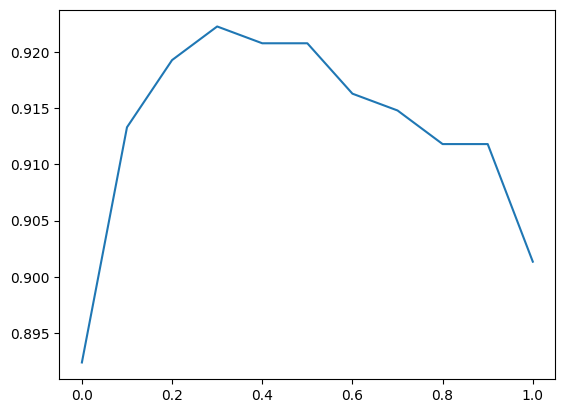

In [ ]:
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, SplittedBallisticTrajectoriesDataset
from tasks.detection import ImportDetectionsTransform
from tqdm.auto import tqdm
from mlworkflow import PickledDataset, TransformedDataset, FilteredDataset
from experimentator import find

ax = plt.figure(figsize=(3,3)).gca()

for filename, label in [("full_ball_detections.pickle", "3 independant images"), ("full_ball_detections.pickle_stitched", "stitched images")]:
    sds = RawSequencesDataset(progress_wrapper=tqdm)
    dataset_folder = sds.dataset_folder
    ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))
    ds = FilteredDataset(ds, lambda k: k.arena_label == "KS-FR-BOURGEB")
    ids = SplittedBallisticTrajectoriesDataset(ds)
    ids = TransformedDataset(ids, [
        ImportDetectionsTransform(
            dataset_folder=dataset_folder,
            filename=filename,
            estimate_pseudo_annotation=False,
            remove_true_positives=False),
    ])
    thresholds = np.linspace(0, 1, 51)
    TPs = np.zeros_like(thresholds)
    FPs = np.zeros_like(thresholds)
    for key in tqdm(ids.keys):
        instant = ids.query_item(key)
        detection = max(instant.detections, key=lambda b: b.value)
        annotation = instant.ball
        pos = lambda b: instant.calibs[annotation.camera].project_3D_to_2D(b.center)
        if np.linalg.norm(pos(detection)-pos(annotation)) < 12:
            TPs += detection.value > thresholds
        else:
            FPs += detection.value > thresholds
    ax.plot(FPs/len(ids.keys), TPs/len(ids.keys), label=label)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
ax.set_xlabel('FP rate')
ax.set_ylabel('TP rate')
plt.legend()

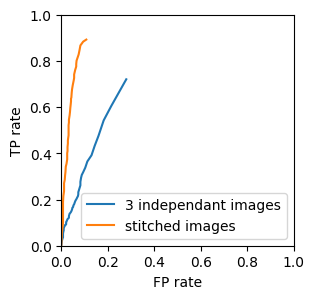

In [85]:
import os
from matplotlib import pyplot as plt
from experimentator import DataCollector
import numpy as np
from pyconfyg import Confyg

# Does adding a randomly initialized first layer alter the perfomances
subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('backbone', 'VGG'), ('pretrained', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with randomly initialized first layer" if ids[experiment_id]['flayer'] else "without"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

NameError: name 'experiment_ids' is not defined

In [ ]:
# Is pre-training on imagenet even necessary
subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('backbone', 'VGG'), ('flayer', False)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "pretrained on imagenet" if ids[experiment_id]['pretrained'] else "random initialization"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does ResNet50 perform better than VGG16?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('with_diff', False), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = ids[experiment_id]['backbone']
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', True)]]):
        ids[experiment_id] = cfg

for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg
    if all([cfg[k] == v for k,v in [('backbone', 'VGG'), ('pretrained', True), ('flayer', True), ('with_diff', True)]]):
        ids[experiment_id] = cfg

        
for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
# Does using difference between two consecutive images help?

subsets = ['testing', 'ballistic']
metrics = [
    ("FLYING Precision", "classification_metrics", lambda x: x['precision'].iloc[1]),
    ("FLYING Recall",    "classification_metrics", lambda x: x['recall'].iloc[1])
]

ids = {}
for experiment_id in experiment_ids:
    cfg = Confyg(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "config.py")).dict
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', False)]]):
        ids[experiment_id] = cfg
    if all([cfg[k] == v for k,v in [('backbone', 'RN50'), ('pretrained', True), ('flayer', True), ('with_diff', True)]]):
        ids[experiment_id] = cfg

        
for subset in subsets:
    fig, axes = plt.subplots(len(metrics), 1, figsize=(5,2), sharex=True)
    fig.suptitle(f"{subset} subset")
    for ax, (name, metric, fct) in zip(axes, metrics):
        for i, experiment_id in enumerate(ids):
            dc = DataCollector(os.path.join(os.environ['RESULTS_FOLDER'], "ballstate", experiment_id, "history.dcp"))
            label = "with_diff" if ids[experiment_id]['with_diff'] else "single image"
            ax.barh(width=fct(dc[f"{subset}_{metric}"]), y=-i, label=label)
            ax.set_yticks([])
            ax.set_ylabel(name, fontsize=7)
            ax.legend()
            ax.set_xlim([0,1])
    plt.show()

In [ ]:
import scipy.optimize
import numpy as np
from matplotlib import pyplot as plt

N = 10
t = np.arange(N)

x0, y0, vx0, vy0 = 10, 10, 5, 40

noise_level = 5

np.random.seed(0)
x_ = x0 + vx0*t + np.random.rand(N)*noise_level
y_ = y0 + vy0*t - 9.81*t**2/2 + np.random.rand(N)*noise_level

indices_list = [
    #({0: (-90, x_[0])}, '1st'),
    #({4: (-90, x_[4])}, "5th"),
    #({-1: (140, x_[-1])}, "last"),
    #({0: (-90, x_[0]), 4: (-90, x_[4])}, '1st and 5th'),
    ({-1: (140, x_[-1]), 4: (-90, x_[4]+100)}, '5th and last'),
    ({-1: (140, x_[-1]+100), -2: (140, x_[-2]+100), 4: (-90, x_[4])}, '5th and 2 lasts'),
    ({-1: (140, x_[-1]), -2: (140, x_[-2]+100), -3: (140, x_[-3]+100), 4: (-90, x_[4])}, '5th and 3 lasts'),
]

fig, axes = plt.subplots(1, len(indices_list), figsize=(16, 3))

for (indices, name), ax in zip(indices_list, axes):
    y = np.array(y_)
    x = np.array(x_)
    for i in indices:
        y[i] = indices[i][0]
        x[i] = indices[i][1]
    
    handles = []
    
    l, = ax.plot(x, y, marker='.', markersize=10, linestyle="", label='noisy data')
    handles.append(l)
    
    l, = ax.plot(x[np.array(list(indices.keys()), dtype=np.int32)], y[np.array(list(indices.keys()), dtype=np.int32)], 'o', markersize=10, markeredgecolor='red', label='outlier', markerfacecolor='None')
    handles.append(l)

    ax.set_title(f"outlier on the {name} data point(s)")
    
    A = np.hstack([np.tile(np.eye(2), (len(t), 1)), np.vstack(np.eye(2)[np.newaxis]*t[...,np.newaxis,np.newaxis])])
    b = np.vstack([np.array([[xi], [yi]]) for xi, yi in zip(x, y)]) - np.vstack(np.eye(2, 1, k=-2)[np.newaxis]*9.81*t[...,np.newaxis,np.newaxis]**2/2)
    
    for igname, initial_guess in {
        #"first": (x[0], y[0], x[1] - x[0], y[1] - y[0]),
        "solve": (np.linalg.inv(A.T@A)@A.T@b).flatten(),
    }.items():

        for optimizer, options in [
            ('least_squares', {'loss': 'linear'}),
            ('least_squares', {'loss': 'huber'}),
            ('least_squares', {'loss': 'cauchy'}),
            #('minimize', {'options': {'norm': -np.inf}}),
            ('minimize', {'options': {'norm': 2}}),
            #('minimize', {'options': {'norm': np.inf}}),
            #('minimize', {'options': {}})
        ]:
            if optimizer == 'minimize':
                def fun(params):
                    x0, y0, vx0, vy0 = params
                    return np.mean(np.sqrt((x0 + vx0*t - x)**2 + (y0 + vy0*t - 9.81*t**2/2 - y)**2))
            else:
                def fun(params):
                    x0, y0, vx0, vy0 = params
                    return np.sqrt((x0 + vx0*t - x)**2 + (y0 + vy0*t - 9.81*t**2/2 - y)**2)

            result = getattr(scipy.optimize, optimizer)(fun, initial_guess, **options)
            label = f"{optimizer}({options})"
            x0, y0, vx0, vy0 = result['x']
            t_ = np.linspace(0, N-1, 100)
            l, = ax.plot(x0 + vx0*t_, y0 + vy0*t_- 9.81*t_**2/2, label=label+igname)
            handles.append(l)
    ax.set_ylim([-100, 150])
    ax.set_xlim([7, 160])
    #ax.set_xticks([])
    #ax.set_yticks([])
fig.legend(handles=handles, loc='lower center', ncols=3, borderaxespad=-0.2)

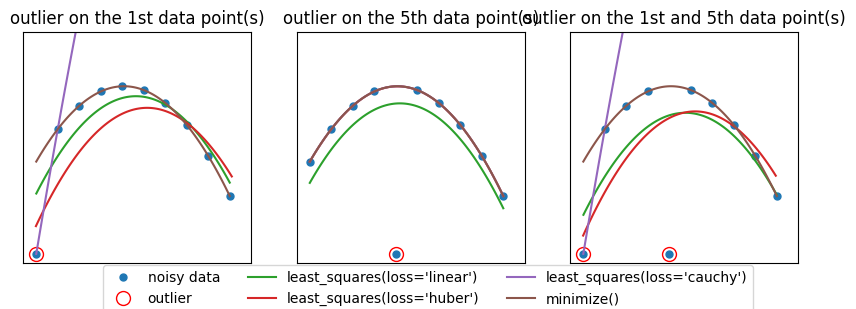

In [ ]:
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt
from deepsport_utilities.court import BALL_DIAMETER
from deepsport_utilities import find
from tqdm.auto import tqdm
import numpy as np

ds = PickledDataset(find("ballsize_dataset.pickle"))
sizes = {}
origins = {}
arenas  = {}
for key in tqdm(ds.keys):
    view = ds.query_item(key)
    arenas.setdefault(key.arena_label, [0])[0] += 1
    sizes.setdefault(view.ball.origin, []).append(view.calib.compute_length2D(BALL_DIAMETER, view.ball.center)[0])
    origins.setdefault(view.ball.origin, [0])[0] += 1
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].hist(list(sizes['annotation']), label='annotations', alpha=.8)
axes[0].hist(list(sizes['interpolation']), label='interpolation', alpha=.8)
axes[0].set_xlabel("ball size [px]")
axes[1].pie([a[0] for a in arenas.values()], labels=list(arenas.keys()))
axes[2].pie([o[0] for o in origins.values()], labels=list(origins.keys()))

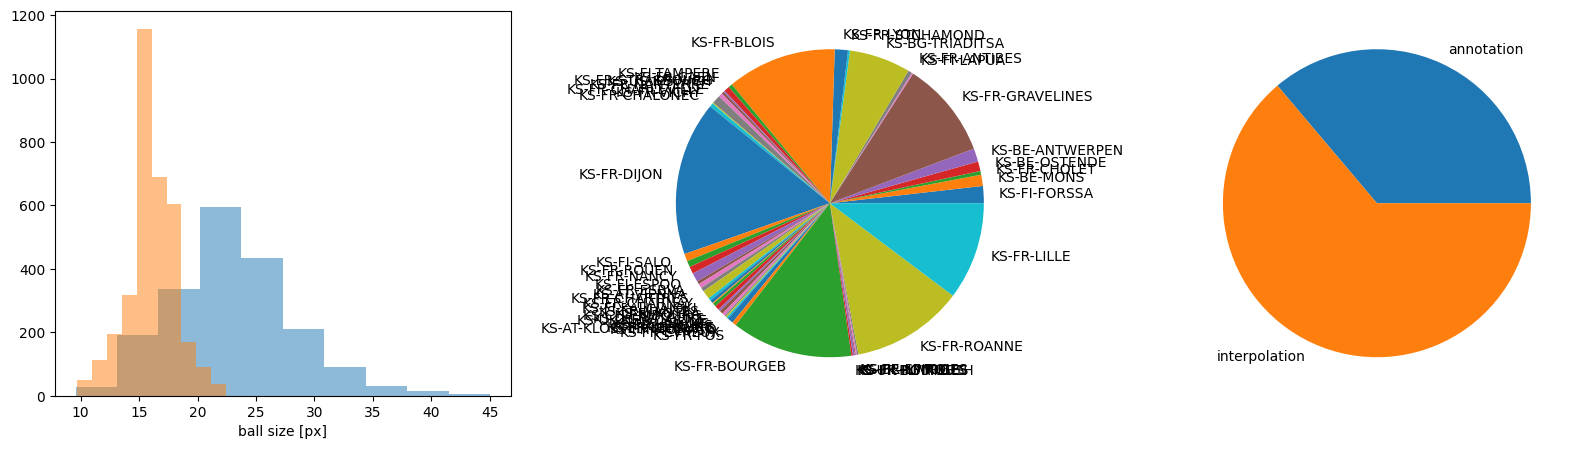

In [ ]:
from experimentator import find
from mlworkflow import PickledDataset
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from deepsport_utilities.utils import color_cycle

ds = PickledDataset(find("ball_states_dataset_with_annotations_and_detections.pickle"))
data = {}
for key in tqdm(ds.keys):
    d = data.setdefault((key.arena_label, key.game_id), {})
    item = ds.query_item(key)
    d.setdefault(item.ball.origin, [0])[0]+=1
    
ax = plt.figure(figsize=(15,4)).gca()
for i, (k, d) in enumerate(data.items()):
    left = 0
    for j, label in enumerate(['ballseg', 'pifball', 'pseudo-annotation', 'annotation', 'interpolation']):
        c = d[label]
        ax.barh(i, c[0], left=left, label=label if i==0 else None, color=color_cycle[j])
        left += c[0]
ax.set_yticks(range(len(data)))
ax.set_yticklabels(list(data.keys()))
ax.legend()

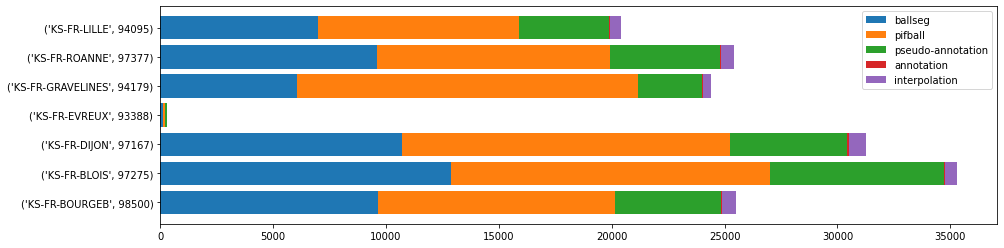

In [ ]:
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from experimentator import find
from matplotlib import pyplot as plt

ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))

d = {}
for k in tqdm(ds.keys):
    l = d.setdefault(k.arena_label, [])
    l.append(len(ds.query_item(k)))
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

for i, (label, l) in enumerate(d.items()):
    axes[0].hist(l, label=label, range=[20, 50], bins=30)
    axes[1].barh(i, len(l), label=label)
axes[1].set_yticks(list(range(len(d))))
axes[1].set_yticklabels(list(d.keys()))
axes[0].set_title("Duration (number of frames) of annotated ballistic trajectories")
axes[1].set_title("Number of annotated ballistic trajectories")
axes[0].legend()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.4, hspace=0.4)

In [ ]:
print(sum([len(v) for v in d.values()]))
print(sum([sum(v) for v in d.values()]))
3679 - 282

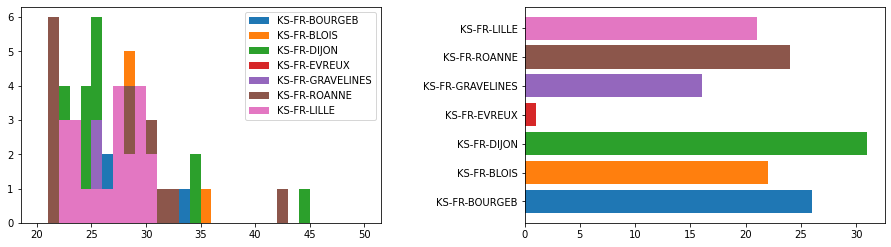

In [ ]:
import boto3
from experimentator.utils import find
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, compute_size_range
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
import os
from matplotlib import pyplot as plt
from deepsport_utilities.utils import color_cycle
import numpy as np

dummy = boto3.Session()
ds = RawSequencesDataset(session=dummy)
ax = plt.figure().gca()
labels = []
for i, key in enumerate(tqdm(ds.yield_keys())):
    item = ds.query_item(key)
    r = compute_size_range(item.calibs)
    #print(key, r)
    ax.barh(left=r[0], y=i, width=r[1]-r[0], color=color_cycle[0])
    labels.append(key.arena_label)
    
from deepsport_utilities.ds.instants_dataset import InstantsDataset, DownloadFlags
from deepsport_utilities import import_dataset

dataset_folder = "/home/gva/repositories/deepsport/ballistic-raw-sequences"

dataset_config = {
    "dataset_folder": dataset_folder,
    "download_flags": DownloadFlags.WITH_ALL_IMAGES | DownloadFlags.WITH_CALIB_FILE,
}

ids = import_dataset(InstantsDataset, os.path.join(dataset_folder, "raw-basketball-sequences-dataset.json"), **dataset_config)
keys = list(ids.keys.all())
for j, label in enumerate(['STRASBOURG', 'GRAVELINES']):
    key = [k for k in keys if label in k.arena_label][0]
    labels.append(key.arena_label)
    item = ids.query_item(key)
    r = compute_size_range(item.calibs)
    color = np.array([255, 127, 14]) # color_cycle[1]
    ax.barh(left=r[0], y=i+j+1, width=r[1]-r[0], color=color/255)
    ax.barh(left=r[0]/2, y=i+j+1, width=(r[1]-r[0])/2, height=.2, color=color/255/2)
ax.set_xlim([0, 60])
ax.set_yticks(list(range(len(labels))))
ax.set_yticklabels(labels)

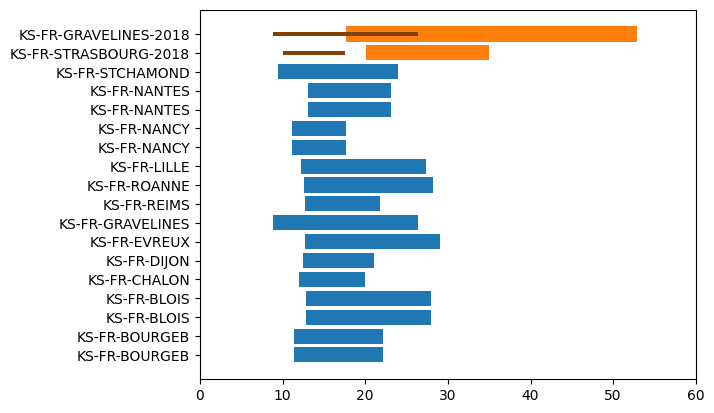

In [ ]:
from dataset_utilities.ds.raw_sequences_dataset import RawSequencesDataset, AddBallStatesTransform, BallState
from deepsport_utilities.utils import color_cycle
import boto3
from tqdm.auto import tqdm
from mlworkflow import TransformedDataset, FilteredDataset
from pprint import pprint
import json
from matplotlib import pyplot as plt

dummy = boto3.Session()
sds = RawSequencesDataset(progress_wrapper=tqdm, session=dummy)
ds = FilteredDataset(sds, lambda k,v: v.ball_states is not None)

states = [BallState(s) for s in range(1,4)]
ax = plt.figure().gca()
labels = []
for i, key in enumerate(ds.yield_keys()):
    labels.append((key.arena_label, key.game_id))
    item = ds.query_item(key)
    filename = os.path.join(sds.dataset_folder, key.arena_label, str(key.game_id), "balls.json")
    data = json.load(open(filename, "r"))
    offset = 0
    for j, s in enumerate(states):
        width = sum([item.ball_states[s][int(k)] if int(k) < len(item.ball_states[s]) else False for k in data.keys()])
        ax.barh(y=i, left=offset, width=width, label=str(s), color=color_cycle[j])
        offset += width
        
ax.legend([str(s) for s in states])
ax.set_yticks(list(range(len(labels))))
ax.set_yticklabels([f"{k[0]} {k[1]}" for k in labels])


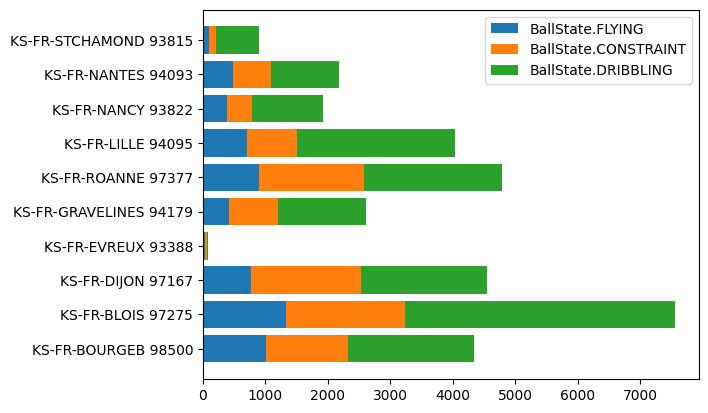

In [ ]:
from deepsport_utilities.utils import color_cycle, find
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt
from dataset_utilities.ds.raw_sequences_dataset import BallState

ds = PickledDataset(find("ballstate_dataset.pickle"))
states = [BallState(s) for s in range(1,4)]
ax = plt.figure().gca()

data = {}
for key in tqdm(ds.yield_keys()):
    d = data.setdefault((key.arena_label, key.game_id), {state: 0 for state in states})
    item = ds.query_item(key)
    d[item.ball.state] += 1

for i, d in enumerate(data.values()):
    left = 0
    for j, (state, count) in enumerate(d.items()):
        ax.barh(y=i, left=left, width=count, label=str(state), color=color_cycle[j])
        left += count

ax.legend([str(s) for s in states])
ax.set_yticks(list(range(len(data))))
ax.set_yticklabels(list(data.keys()))


In [ ]:
from mlworkflow import PickledDataset
from experimentator import find

ds = PickledDataset(find("sds_balls_dataset.pickle"))
print(len(ds.keys))
print(set([k.arena_label for k in ds.keys]))

In [ ]:
ds = PickledDataset(find("balltracker-dataset-full.pickle"))
print(len(ds.keys))
print(set([k.arena_label for k in ds.keys]))

In [ ]:
ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))

print(" ".join(set([k.arena_label for k in ds.keys])))

In [ ]:
from experimentator import find
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt

ds = PickledDataset(find("instants_ballistic_trajectories_600ms_filtered.pickle"))
d = {}
e = {}
f = {}
for k in tqdm(ds.keys):
    d.setdefault(k.arena_label, [0])[0] += 1
    e.setdefault(k.arena_label, [0])[0] += len(ds.query_item(k))
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].pie([x[0] for x in d.values()], labels=list(d.keys()))
axes[0].set_title("number of annotated ballistic sequences")
axes[1].pie([x[0] for x in e.values()], labels=list(e.keys()))
axes[1].set_title("number of annotated ballistic instants")
from pprint import pprint
pprint(e)
d = {}
#for name in ['evreux2', 'dijon', 'gravelines', 'lille', 'roanne', 'blois', 'bourgeb']:
#    ds = PickledDataset(find(f"{name}_ballpos_dataset.pickle"))
#    for k in tqdm(ds.keys):
#        d.setdefault(k.arena_label, [0])[0] += len(ds.query_item(k).ball_annotations)
#fig, axes = plt.subplots(1, 2)
#axes[0].pie([a[0] for a in d.values()], labels=list(d.keys()))
#axes[0].set_title("number of annotated ballistic sequences")


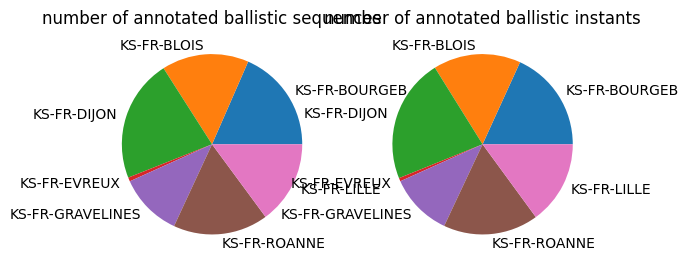

In [ ]:
from experimentator import find
from tqdm.auto import tqdm
from mlworkflow import PickledDataset
from matplotlib import pyplot as plt

d = {}
for name in ['evreux2', 'dijon', 'gravelines', 'lille', 'roanne', 'blois', 'bourgeb']:
    ds = PickledDataset(find(f"{name}_ballpos_dataset.pickle"))
    for k in tqdm(ds.keys):
        d.setdefault(k.arena_label, [0])[0] += len(ds.query_item(k).ball_annotations)
fig, axes = plt.subplots(1, 2)
axes[0].pie([a[0] for a in d.values()], labels=list(d.keys()))
axes[0].set_title("number of annotated ballistic sequences")


In [ ]:
from experimentator import find, CachedPickledDataset
from mlworkflow import PickledDataset
import numpy as np
from tqdm.auto import tqdm
ds = CachedPickledDataset(find("sds_balls_dataset.pickle"))
print(dict(zip(*np.unique([ds.query_item(k).ball.state for k in tqdm(ds.keys)], return_counts=True))))